# Optimization tests

## CAVI

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import time 
import tqdm
import math
from scipy.special import softmax,expit
import torch
%matplotlib inline
from torch.autograd import Variable


In [2]:
if torch.__version__ != '1.10.0':
    print('You need to upgrade PyTorch before running this code.')

else:
    print('Ready to go!')

Ready to go!


# Model definition 

In [71]:
class BinaryTS:
    
    def __init__(self,d=10,T=10,N=10, true_A=None, true_B=None, true_sigma=None,R=10000):
        
        """
        Instanciates the binaryTS model. 
        
        Arguments: 
        
        - d: dimension of the model. 
        - A: (d,d) matrix that controls the dynamics related to the observed state. 
        - B: (d,d) matrix that controls the dynamics related to the latent state. 
        - sigma: (d,d) positive definite matrix that controls the variance of the noise. 
        - R: number of MCMC samples for expectation approximations used in VEM. 
        
        By default, the BinaryTS model is instanciated with random matrices A, B and sigma. You can provide your 
        own, but B should have all its eigenvalues of module less than 1 in order to enforce stability of the model
        (see companion paper for further information). 
        
        """
        
        self.d = d
        self.T = T
        self.N = N
        
        if true_A is None:
            self.true_A = 0.8*np.identity(d) 
        else: 
            self.true_A = true_A
            
        if true_B is None:     
            random_eig = np.random.uniform(low=-0.7,high=0.7,size=d) 
            self.true_B = np.diag(random_eig) 
        else:
            self.true_B = true_B
        
        if true_sigma is None:
            random_matrix = np.random.randn(d,d)
            self.true_sigma = np.dot(random_matrix,random_matrix.T)
            
        else:
            self.true_sigma = true_sigma
        
        self.true_sigma_inv = np.linalg.inv(self.true_sigma)
        self.data = None
        self.R = R
        
        
        
    ### Util functions###
    
    def sample(self,N=100,T=100,fixdata=True):
        
        """
        Samples N samles over T timesteps from the DGP. If fixdata is set to True, sampled x data is saved in 
        an attribute called self.data, along with (N,T) used for sampling in self.N and self.T. 
        """
        
        x_data = np.zeros((N,self.d,T))
        z_data = np.zeros((N,self.d,T))
        p_data = np.zeros((N,self.d,T))
        
        self.z0 = np.random.randn(self.d,N)
        p = expit(self.z0)
        self.x0 = np.random.binomial(1,p,size=(self.d,N))
        
        x = self.x0
        z = self.z0
        
        x_data[:,:,0] = self.x0.T
        z_data[:,:,0] = self.z0.T
        p_data[:,:,0] = p.T
        
        for t in np.arange(1,T): 
            z = self.true_A@x + self.true_B@z + np.random.multivariate_normal(mean=np.zeros(self.d),cov=self.true_sigma,size=N).T
            p = expit(z)
            x = np.random.binomial(1,p,size=(self.d,N))
            x_data[:,:,t] = x.T
            z_data[:,:,t] = z.T
            p_data[:,:,t] = p.T
            
        if fixdata: 
            self.data = x_data
            self.N = N
            self.T = T
        
        return x_data,z_data,p_data
    
    def snapshot(self,N,T,x_data=None,z_data=None,p_data=None,pltdim = 3,plttime=500,save=False): 
        
        """
        Generates and plots some data from the data generating process. This method displayes three components 
        of the DGP for every dimension: 
        - the observed, 0-1 valued process
        - the latent state
        - the probability associated to the current latent state obtained through softmaxification. 
        
        Arguments:
        
        - N: number of individuals (for plotting, one is choosen at random).
        - T: number of timesteps over which data is generated. 
        - x_data, z_data, p_data: allows to pass previously generate data for plotting (instead of 
        generating new observations).
        - pltdim: number of dimensions plotted. 
        - plttime: number of timesteps plotted. 
        - save: if set to True, a .pdf of the generated image is saved. 
        """
        
        if x_data is None and z_data is None and p_data is None: 
            x_data,z_data,p_data = self.sample(N=N,T=T,fixdata=False)
            
        plttime = np.minimum(T,plttime)
        pltdim = np.minimum(pltdim,self.d)
        random_ind = np.random.randint(0,N)
        
        sns.set_context('talk')
        sns.set_style('white')
            
        f,ax=plt.subplots(pltdim,3,figsize=(pltdim*30,pltdim*13))
        f.suptitle('Observed state, hidden state and transition probability by dimension of the model',fontsize=65,fontweight='heavy')
                
        for i in np.arange(pltdim):
        
            ax[i,0].plot(x_data[random_ind,i,:plttime],c='orange')
            ax[i,1].plot(z_data[random_ind,i,:plttime],c='red')
            ax[i,2].plot(p_data[random_ind,i,:plttime],c='green')
            
                        
            ax[i,0].set_yticks([0,1])
            
            for a in ['left','bottom']:
            
                ax[i,0].spines[a].set_linewidth(2.5)
                ax[i,1].spines[a].set_linewidth(2.5)
                ax[i,2].spines[a].set_linewidth(2.5)
            
            for j in [0,1,2]:
                ax[i,j].spines["right"].set_visible(False)
                ax[i,j].spines["top"].set_visible(False)
                ax[i,j].tick_params(axis='both', labelsize=50)
        
        
        ax[pltdim-1,0].set_xlabel('Observed state',fontsize=55,fontweight='bold',labelpad=20)
        ax[pltdim-1,1].set_xlabel('Hidden state',fontsize=55,fontweight='bold',labelpad=20)
        ax[pltdim-1,2].set_xlabel('Transition probability',fontsize=55,fontweight='bold',labelpad=20)
        
        plt.tight_layout()
        
        if save: 
            
            plt.savefig('snapshot.pdf')
    
    
    ### Functions for VEM ###
    
    def variance_initialization(self,random=False): 
        
        """
        Returns an initialization (at random or deterministic) for the diagonal and subdiagonal elements 
        of the B matrix that parametrizes the variational density, as a (self.d,2*self.T+1)-tensor. 
        For every line d, the first self.T+1 elements are the diagonal elements of the Cholesky decomposition 
        of the precision matrix of dimension d, while the next self.T elements are the subdiagonal elements. 
        
        The precision matrices (there are d of them) can be obtained by calling 
        self.compute_precision(self.form_B(self.variance_initialization())).
        
        """
        if random is False:
            return torch.ones(self.N,self.d,self.T-1), torch.ones(self.N,self.d,self.T-2)
        else:
            return torch.rand(self.N,self.d,self.T-1), torch.rand(self.N,self.d,self.T-2)
    
    
    def form_B(self,nu,omega): 
        
        """
        Given a (N,d,T-1) nu-tensor and a (N,d,T-2) omega-tensor as inputs, forms a (N,d,T-1,T-1) tensor that 
        collects for every individual the (d,T-2,T-2) tensor that parametrizes the variance of her 
        variational density.

        """
        
        B=torch.diag_embed(nu)+torch.diag_embed(omega,offset=1)
        
        return B

    
    def compute_precision(self,B): 
        
        """
        Given a (N,d,T-1,T-1) tensor as input formed by self.form_B, forms a (N,d,T-1,T-1) tensor that collects
        for every individual the (d,T-2,T-2) tensor that collects all precision matrices for all dimensions by
        recomposing the precision matrices from the Cholesky decomposition.
        """
        
        return torch.transpose(B,dim0=2,dim1=3)@B
    
    def compute_covmat(self,nu,omega): 
        
        """
        Given a (N,d,T-1) nu-tensor and a (N,d,T-2) omega-tensor as inputs that parametrize the variance-covariances
        of the variational distribution, computes the variance-covariance matrix, a (N,d,T-1,T-1) semidefinite positive
        and symmetric tensor. 
        """
        
        return torch.linalg.inv(self.compute_precision(self.form_B(nu,omega)))
    
    def check_data(self):
        
        """
        Util function to check wether self.data is empty.
        """
        
        if self.data is None: 
            raise ValueError('self.data is empty. Use self.sample(args,fixdata=True) to sample some data first.')
    
    def log_expectation(self):
    
        """
        For every of the (N,d,T-1) latent variable z, approximates the expectation 
        
                                        E_z(log 1+exp(z))
                                        
        via MCMC sampling with R samples. Returns a (N,d,T-1) tensor of approximated expectations. 
        
        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        nu = self.var_approx[:,:,:T-1]
        omega = self.var_approx[:,:,T-1:]
        
        #Compute covariance matrix of latent variables 
        covariance_matrix = self.compute_covmat(nu,omega)
        
        #Extract the diagonal terms that correspond to the variance terms. These terms form a (N,d,T-1) tensor.
        diagonal_terms = torch.diagonal(covariance_matrix,offset=0,dim1=2,dim2=3)
        
        #Take the square root of the terms for gaussian centered scaling.
        
        variance_scaled = torch.pow(diagonal_terms,1/2)
        
        #Draw of random N(0,1) variables 
        
        random_draw = torch.randn(R,N,d,T-1)
        scaled_draw = variance_scaled*random_draw + self.mu_approx
        
        return scaled_draw.mean(axis=0)
    
    def compute_bilinear_term(self):
        
        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        #batchsize=self.batchsize
        #batch=self.batch
       
        sigma_inv = self.sigma_inv
        
        
        data = torch.from_numpy(self.data).type(torch.FloatTensor)
                        
        result = sum([torch.trace(self.mu_approx[i,:,:].T@sigma_inv@(self.mu_approx[i,:,:])) for i in np.arange(N)])
        result += -sum([torch.trace((self.mu_approx[i,:,1:].T@sigma_inv@(self.A@(data[i,:,:-1])))) for i in np.arange(N)])
        result += -sum([torch.trace(self.mu_approx[i,:,1:].T@sigma_inv@self.B@(self.mu_approx[i,:,:T-1])) for i in np.arange(N)])
        
        result += -sum([torch.trace((self.A@(data[i,:,:-1])).T@sigma_inv@(self.mu_approx[i,:,1:])) for i in np.arange(N)])
        result += sum([torch.trace((self.A@(data[i,:,:-1])).T@sigma_inv@(self.A@(data[i,:,:-1]))) for i in np.arange(N)])
        result += sum([torch.trace((self.A@(data[i,:,:-1])).T@sigma_inv@self.B@(self.mu_approx[i,:,:-1])) for i in np.arange(N)])
        
        result += -sum([torch.trace(self.mu_approx[i,:,:-1].T@(self.B.T)@sigma_inv@(self.mu_approx[i,:,1:])) for i in np.arange(N)])
        result += sum([torch.trace((self.mu_approx[i,:,:-1].T@(self.B.T)@sigma_inv@(self.A@(data[i,:,:-1])))) for i in np.arange(N)])
        result += sum([torch.trace(self.mu_approx[i,:,:-1].T@(self.B.T)@sigma_inv@self.B@(self.mu_approx[i,:,:-1])) for i in np.arange(N)])
        
        result *= 1/2
        
        return result   
        
    def compute_elbo(self):
        
        """
        Returns the Evidence Lower Bound (ELBO) of the model, normalized by 1/(N*T*d), as a pytorch tensor.
        """
        
        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        self.construct_mu()
        self.construct_var()
        
        nu = self.var_approx[:,:,:T-1]
        omega = self.var_approx[:,:,T-1:]
        
        #batchsize = self.batchsize
        #self.batch = np.random.choice(N,batchsize,replace=False)
        #batch = self.batch
                
        sigma_inv = self.sigma_inv
        data = torch.from_numpy(self.data).type(torch.FloatTensor)
        var_approx = self.compute_precision(self.form_B(nu,omega))
        covariance_matrix = self.compute_covmat(nu,omega)
        
        # Compute logdet of sigma_inv
        entropy = ((T-1)*N/2)*torch.logdet(sigma_inv)
        
        #Compute logdet of variational density
        
        var_approx_logdet = torch.log(nu).sum()
                
        #Compute bilinear term
        
        bilinear_term = self.compute_bilinear_term()
        
        #Compute data dependent sum and approximated expectation
        
        mu_x_prod = (self.mu_approx*data[:,:,1:]).sum()
        
        expectation_approximation = self.log_expectation().sum()
                                
        #Compute trace term
        
        diagonal_terms = torch.diagonal(covariance_matrix,offset=0,dim1=2,dim2=3)
        sub_diagonal_terms = torch.diagonal(covariance_matrix,offset=1,dim1=2,dim2=3)
        
        trace_term = sum([((torch.diagonal(sigma_inv))*(diagonal_terms[i,:,1:])).sum(axis=[0,1]) for i in np.arange(N)])
        trace_term += sum([((torch.diagonal(self.B.T@sigma_inv@self.B))*(diagonal_terms[i,:,:-1])).sum(axis=[0,1]) for i in np.arange(N)])
        trace_term += -sum([((torch.diagonal(sigma_inv@self.B)*(sub_diagonal_terms[i,:,:]))).sum(axis=[0,1]) for i in np.arange(N)])
        trace_term += -sum([((torch.diagonal(self.B.T@sigma_inv)*(sub_diagonal_terms[i,:,:]))).sum(axis=[0,1]) for i in np.arange(N)])
        
        trace_term = 1/2*trace_term 
        
        #Put all terms together
            
        elbo_value = entropy-2*var_approx_logdet + mu_x_prod -expectation_approximation - bilinear_term  - trace_term 
        
        return (1/N)*elbo_value
    
    def define_tracks(self):
        
        """
        Util function that defines empty tensors for saving training results. 
        
        """
        
        self.elbo_track = torch.zeros(1)
        
        self.predicted_likelihood_track = torch.zeros(1)
        
        self.A_grad_track = torch.zeros(1)
        self.B_grad_track = torch.zeros(1)
        self.sigma_inv_grad_track = torch.zeros(1)
        self.mu_approx_grad_track = torch.zeros(1)
        self.var_approx_grad_track = torch.zeros(1)
        
        self.mu_approx_track = torch.zeros(self.d,self.T)
        self.var_approx_track = torch.zeros(self.d,self.T,self.T)
        
        self.A_track = torch.zeros(self.d,self.d)
        self.A_error_track = torch.zeros(1)
        
        self.B_track = torch.zeros(self.d,self.d)
        self.B_error_track = torch.zeros(1)
        
        self.sigma_inv_track = torch.zeros(self.d,self.d)
        self.sigma_inv_error_track = torch.zeros(1)
    
    def save_results(self,save_grad=True): 
        
        """
        Util function that saves current values of
            - the ELBO (Evidence Lower Bound), which is the objective function that is maximized ;
            - mu_approx, a (d,T+1)-tensor that encodes the variational mean parameters ;
            - var_approx, a (d,T+1,T+1)-tensor that encodes the variational variance parameters ;
        
        and the current estimated values of 
            - A, B and sigma, three (d,d)-tensors that govern the dynamics of the latent space. 
            
        This function also saves the difference in Froebenius norm between these estimates and the 
        real parameters of the model. 
        
        Before calling this function, you need to define 
            - self.elbo_track
            - self.mu_approx_track
            - self.var_approx_track
            - self.A_track
            - self.A_error_track
            - self.B_track
            - self.B_error_track
            - self.sigma_track
            - self.sigma_error_track
            
        as empty tensors. This can be done by calling the util function self.define_tracks().  
        
        torch.no_grad() ensures that the saving of results does not result in unecessary gradient saving.
        
        """
        
        with torch.no_grad():
            
            #Save ELBO
            
            self.elbo_track = torch.cat((self.elbo_track,torch.tensor([-self.elbo])))
            
            #Save predicted likelihood
            
            #self.predicted_likelihood_track = torch.cat((self.predicted_likelihood_track,torch.tensor([self.predictive_likelihood(N=100,T=50)])))
            
            #Save gradients
            
            #self.A_grad_track = torch.cat((self.A_grad_track, torch.tensor([torch.linalg.norm(self.A.grad)])))
            #self.B_grad_track = torch.cat((self.B_grad_track, torch.tensor([torch.linalg.norm(self.B.grad)])))
            #self.sigma_inv_grad_track = torch.cat((self.sigma_inv_grad_track, torch.tensor([torch.linalg.norm(self.sigma_inv.grad)])))
            #mu_grad = (sum([(self.mu_dic[key]["variable"].grad)**2 for key in self.mu_dic.keys()]))**(1/2)
            #self.mu_approx_grad_track = torch.cat((self.mu_approx_grad_track, torch.tensor([mu_grad])))
            #var_grad = (sum([(self.var_dic[key]["variable"].grad)**2 for key in self.var_dic.keys()]))**(1/2)
            #self.var_approx_grad_track = torch.cat((self.var_approx_grad_track, torch.tensor([var_grad])))
            
            #Save mu_approx results
            
            #self.mu_approx_track = torch.cat((self.mu_approx_track,self.mu_approx))
            
            #Save var_approx results
            
            #cholesky_dec = self.form_B(self.var_approx)
            #precision_matrix = self.compute_precision(cholesky_dec)
            #self.var_approx_track = torch.cat((self.var_approx_track,precision_matrix))
            
            #Save A results
            
            self.A_track = torch.cat((self.A_track,self.A))
            A_error = torch.tensor([torch.norm(torch.tensor(self.true_A)-self.A)])
            self.A_error_track = torch.cat((self.A_error_track,A_error))
            
            #Save B results
            
            self.B_track = torch.cat((self.B_track,self.B))
            B_error = torch.tensor([torch.norm(torch.tensor(self.true_B)-self.B)])
            self.B_error_track = torch.cat((self.B_error_track,B_error))
            
            #Save sigma results
            
            self.sigma_inv_track = torch.cat((self.sigma_inv_track,self.sigma_inv))
            sigma_inv_error = torch.tensor([torch.norm(torch.tensor(self.true_sigma_inv)-self.sigma_inv)])
            self.sigma_inv_error_track = torch.cat((self.sigma_inv_error_track,sigma_inv_error))                
        
    def construct_mu(self):
        
        """
        Forms a (d,T+1)-tensor representing mu, the variational mean parameter, from the mu_dic dictionnary. 
        This is necessary to implement coordinate-ascent in Pytorch. 
        
        """
        
        self.mu_approx = torch.zeros(self.N,(self.T-1)*self.d)
        
        for i in np.arange(self.N): 
            for j in np.arange(0,(self.T-1)*self.d):
                key = str(j)
                variable = self.observations_dic[str(i)]['mean'][key]['variable']
                self.mu_approx[i,j] = variable
            
        self.mu_approx = self.mu_approx.reshape(self.N,d,self.T-1)
        
    def construct_var(self):
        
        """
        Forms a (d,2*T+1)-tensor representing the set of lambda_i's, the variational variance parameters,
        from the var_dic dictionnary. This is necessary to implement coordinate-ascent in Pytorch. 
        
        """
        
        self.var_approx = torch.zeros(self.N,self.d*(2*self.T-3))
        
        for i in np.arange(self.N): 
            for j in np.arange(0,(2*self.T-3)*self.d):
                key = str(j)
                variable = self.observations_dic[str(i)]['variance'][key]['variable']
                self.var_approx[i,j] = variable
            
        self.var_approx = self.var_approx.reshape(self.N,d,2*self.T-3)
        
    def cavi_optimizers(self,latent_lrs,mu_lr,var_lr): 
        
        """
        Util function that creates three dictionnaries that store variables, optimizers and learning rates for
        coordinate-ascent optimization.
        Specifically, this method creates 
        
            - latent_dic, a dictionnary that contains self.A, self.B and self.sigma_inv
            and their optimization parameters (Pytorch optimizer and learning rate);
            
            - observations_dic, a dictionnary that contains, for every individual, a subdictionnary containing 
            their variational variables with associated PyTorch optimizers and learning rates. This dictionnary is
            structured as follows: observations_dic <- For every N, an individual_dic <- For every individual_dic, 
            a var_approx_dic and a mu_approx_dic that contain all the variance and mean parameters. 
        
        """
        
        self.latent_dic = {"A":{},"B":{},"sigma_inv":{}}
        
        self.latent_dic["A"]['variable']= self.A
        self.latent_dic["B"]['variable']= self.B
        self.latent_dic["sigma_inv"]['variable']= self.sigma_inv

        for i,key in enumerate(self.latent_dic.keys()):

            self.latent_dic[key]["lr"] = latent_lrs[i]
            self.latent_dic[key]["optimizer"] =torch.optim.Adam([self.latent_dic[key]['variable']],lr=self.latent_dic[key]['lr'])

        self.observations_dic ={}
        
        
        #Mean and variance intializations happen here !
        self.mu_approx = torch.ones(N,d,T-1)
        self.var_approx = torch.ones(N,d,2*T-3)
        
        for individual in np.arange(self.N):
            individual = str(individual)
            self.observations_dic[individual] = {}
            self.observations_dic[individual]['mean'] = {}
            self.observations_dic[individual]['variance'] = {}
            
            for i,line in enumerate(self.mu_approx[int(individual),:,:]):
                for k,coordinate in enumerate(line):
                    key = str(i*(self.T-1)+k)
                    self.observations_dic[individual]['mean'][key] ={}
                    self.observations_dic[individual]['mean'][key]['variable'] = coordinate
                    self.observations_dic[individual]['mean'][key]['variable'].requires_grad = True
                    self.observations_dic[individual]['mean'][key]['optimizer'] = torch.optim.Adam([self.observations_dic[individual]['mean'][key]['variable']],lr=mu_lr)
            
            for i,line in enumerate(self.var_approx[int(individual),:,:]):
                for k,coordinate in enumerate(line):
                    key = str(k+i*(2*self.T-3))
                    self.observations_dic[individual]['variance'][key] ={}
                    self.observations_dic[individual]['variance'][key]['variable'] = coordinate
                    self.observations_dic[individual]['variance'][key]['variable'].requires_grad = True
                    self.observations_dic[individual]['variance'][key]['optimizer'] = torch.optim.Adam([self.observations_dic[individual]['variance'][key]['variable']],lr=mu_lr)
        
        
        #These last two lines are necessary to convert the dictionnary into two tensors (one for mean and the other
        #one for variance parameters). 
        
        self.construct_mu()
        self.construct_var()


    def block_cavi(self,latent_lrs=[1e-2,1e-2,1e-4],mu_lr=1e-2,var_lr=1e-2,max_iter=100,its=2,batchsize=2): 
        
        """
        Optimization of the ELBO using a block-coordinate-ascent algorithm. 
        
        Arguments: 
            - latent_lrs (list): learning rates for resp. A, B and sigma;
            
            - mu_lr (scalar > 0): learning rate for the variational density mean parameters;
            
            - var_lr (scalar > 0): learning rate for the variational density variance parameters. 
        
        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        #self.batchsize=batchsize
        
        self.sample(N=N,T=T)
        
        #Create test data
        #self.testN = 50
        #self.testT = 50
        
        #self.test_data = self.sample(N=self.testN,T=self.testT,fixdata=False)
        
        #self.true_pred_log = self.true_predictive_likelihood(N=self.testN,T=self.testT)
        
        #Parameters initialization
        
        sigma = 0.5*torch.eye(self.d,self.d)
        self.sigma = sigma
        self.sigma_inv = torch.linalg.inv(self.sigma)
        self.sigma_inv.requires_grad=True
        
        A = torch.ones(self.d,self.d) + torch.randn(self.d,self.d)
        A.requires_grad = True
        self.A = A
        
        B = 0.5*torch.ones(self.d,self.d)+torch.randn(self.d,self.d)
        B.requires_grad = True
        self.B = B
        
        print('data shape:', self.data.shape)
            
        self.define_tracks()
        
        # Calling self.cavi_optimizers(*args) also intializes the variational parameters. 
        t1 = time.time()
        self.cavi_optimizers(latent_lrs,mu_lr,var_lr)
        t2 = time.time()
        defoptim_time = t2-t1
        
        n_params = 3 + (T-1)*d + d*(2*T-3)
        
        print('-----------------------------------------')
        print('---------------------------------')
        print('--------------------------')
        print('-------------------')  
        print('\n')
        print('Block-CAVI initialization...')
        print('Initializing the optimizers took', defoptim_time, ' seconds.')
        print('\n')
        print('--------Dimensions of the model--------')
        print('T: ', T)
        print('d: ', d)
        print('N: ', N)
        print('\n')
        print('-------- Optimization parameters --------')
        print('\n')
        print('Optimizer for A:', self.latent_dic['A']['optimizer'] )
        print('Optimizer for B:', self.latent_dic['B']['optimizer'] )
        print('Optimizer for sigma_inv:', self.latent_dic['sigma_inv']['optimizer'] )
        print('Optimizer for mu_approx:', self.observations_dic['0']['mean']['0']['optimizer'] )
        print('Optimizer for var_approx:', self.observations_dic['0']['variance']['0']['optimizer']  )
        print('\n')
        print('-------------------') 
        print('--------------------------')
        print('---------------------------------')
        print('-----------------------------------------')
        print('\n')
        print('\n')
        print('-------- TRAINING STARTS --------')
        print('\n')
        print('\n')
        
        
        t1 = time.time()
        
        for t in np.arange(max_iter):
        
            random_order = np.random.permutation(np.arange(n_params))
            random_individual_order = np.random.permutation(np.arange(N))
            
            
            for j in random_order: 
                
                if j in [0,1,2]: 
                    
                    parameter = list(self.latent_dic.keys())[j]
                    optimizer = self.latent_dic[parameter]["optimizer"]
                    
                    for it in np.arange(its):
                        self.elbo = -self.compute_elbo()
                        self.elbo.backward(retain_graph=True)
                        optimizer.step()
                        optimizer.zero_grad()
                        
                    
                if j in np.arange(3,(T-1)*d+3): 
                
                    j += - 3
                    
                    for i in random_individual_order: 

                        parameter = list(self.observations_dic[str(i)]['mean'].keys())[j]
                        optimizer = self.observations_dic[str(i)]['mean'][parameter]["optimizer"]
                        
                        for it in np.arange(its):
                            self.elbo = -self.compute_elbo()
                            self.elbo.backward(retain_graph=True)
                            optimizer.step()
                            optimizer.zero_grad()
                    
                if j >= (T-1)*d+3:
                    
                    j += -((T-1)*d+3)
                    
                    for i in random_individual_order: 

                        parameter = list(self.observations_dic[str(i)]['variance'].keys())[j]
                        optimizer = self.observations_dic[str(i)]['variance'][parameter]["optimizer"]
                        
                        for it in np.arange(its):
                            self.elbo = -self.compute_elbo()
                            self.elbo.backward(retain_graph=True)
                            optimizer.step()
                            optimizer.zero_grad()

                    
            if t%10 == 0 and t > 1:
                print('---------- Iteration ', t, ' ---------- ')
                      
                print('Current ELBO value: ', -self.elbo)
                
                print('Difference w. average of last 10 value (should be > 0): ', -self.elbo - self.elbo_track[-10:].mean())
                
                #print('Average of last 10 PL (should increase): ', self.predicted_likelihood_track[-10:].mean())
                      
            
            self.save_results()
            #print(self.predictive_likelihood(N=self.testN,T=self.testT))
            
        t2 = time.time()
        
        print('-------- TRAINING FINISHED IN ', t2-t1, ' SECONDS --------')

## Model specification

In [106]:
d = 2
T = 3
N = 1

In [107]:
true_A = np.identity(d) + np.random.randn(d,d)
true_B = np.diag(np.random.uniform(low=-0.8,high=0.8,size=d)) 

#small_noise = 1/2*np.random.randn(1)
true_sigma = np.diag(np.random.uniform(low=1,high=4,size=d)) 

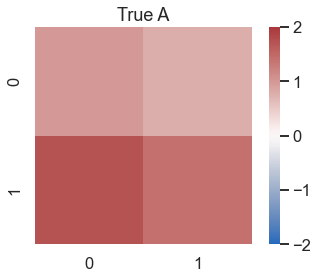

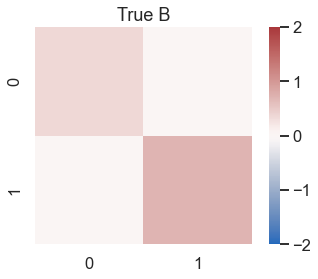

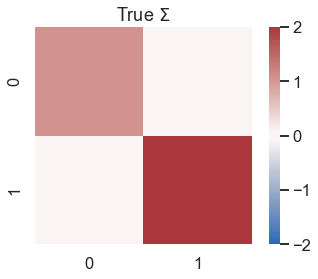

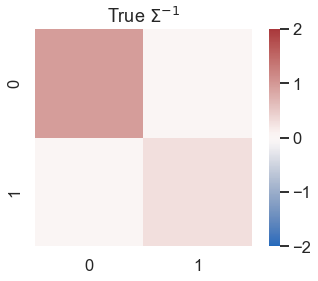

In [108]:
sns.heatmap(true_A,square=True,cmap='vlag',vmin=-2,vmax=2)
plt.title('True A')
plt.show()
sns.heatmap(true_B,square=True,cmap='vlag',vmin=-2,vmax=2)
plt.title('True B')
plt.show()
sns.heatmap(true_sigma,square=True,cmap='vlag',vmin=-2,vmax=2)
plt.title('True $\Sigma$')
plt.show()
sns.heatmap(np.linalg.inv(true_sigma),square=True,cmap='vlag',vmin=-2,vmax=2)
plt.title('True $\Sigma^{-1}$')
plt.show()

In [109]:
bints = BinaryTS(d=d,T=T,N=N,true_A = true_A,true_B=true_B,true_sigma = true_sigma)

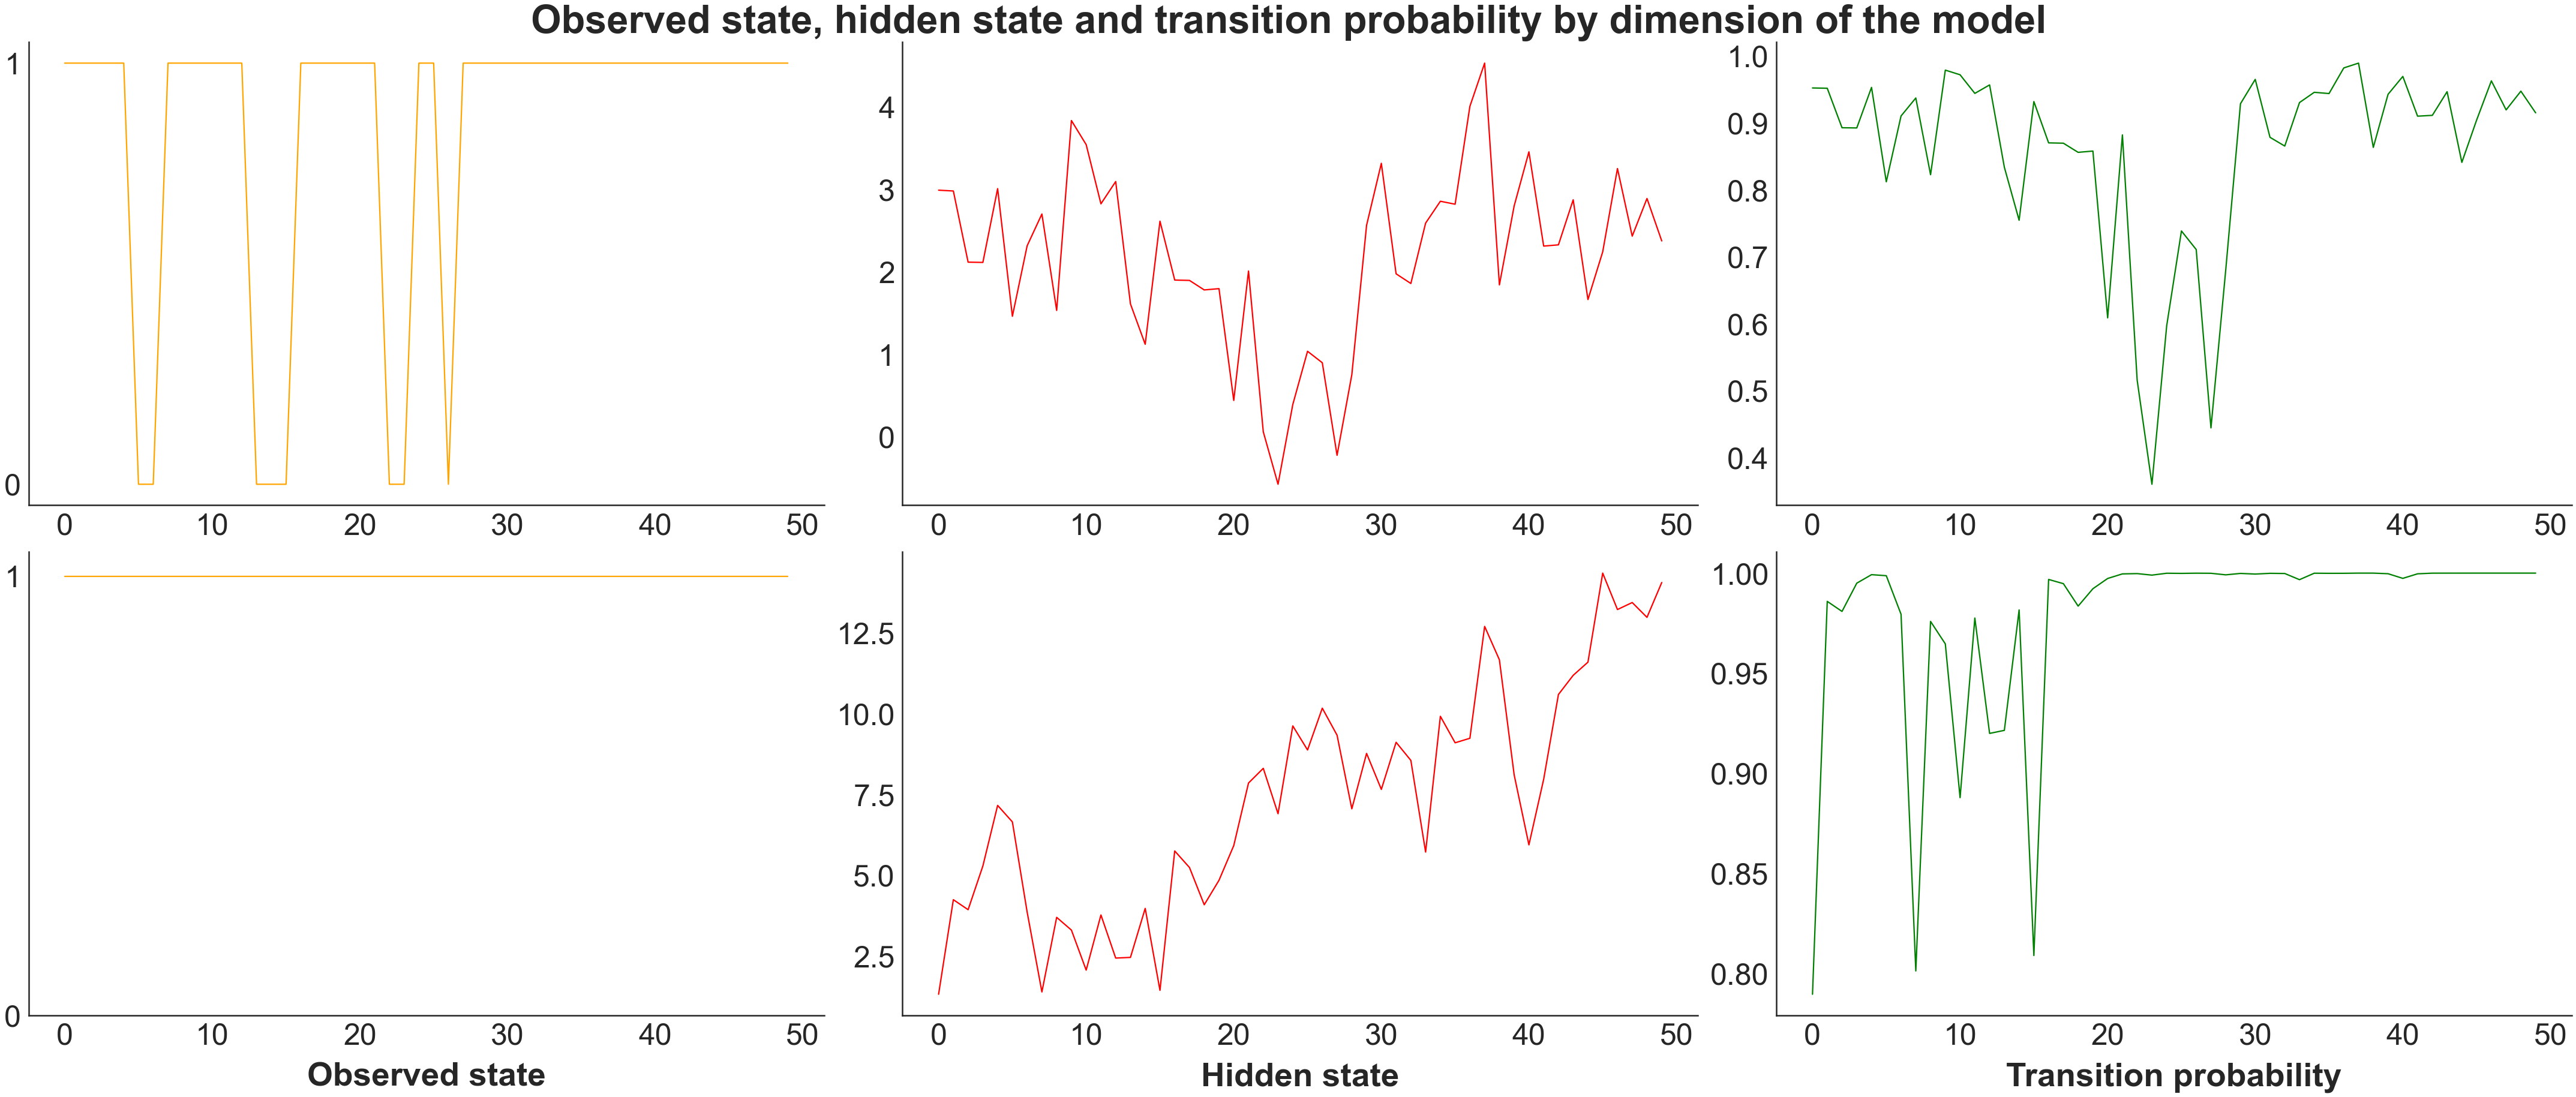

In [110]:
bints.snapshot(N=2,T=50)

This cell performs coordinate-wise gradient ascent, a standard method for maiximizing the ELBO in variational inference. 

In [114]:
bints.block_cavi(latent_lrs=[1e-3,1e-3,1e-3],mu_lr=1e-4,var_lr=1e-4,max_iter=5000,its=10,batchsize=50)

data shape: (1, 2, 3)
-----------------------------------------
---------------------------------
--------------------------
-------------------


Block-CAVI initialization...
Initializing the optimizers took 0.0012469291687011719  seconds.


--------Dimensions of the model--------
T:  3
d:  2
N:  1


-------- Optimization parameters --------


Optimizer for A: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Optimizer for B: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Optimizer for sigma_inv: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Optimizer for mu_approx: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
Optimizer for var_approx: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999

---------- Iteration  370  ---------- 
Current ELBO value:  tensor(-2.8615, grad_fn=<NegBackward0>)
Difference w. average of last 10 value (should be > 0):  tensor(0.0340, grad_fn=<SubBackward0>)
---------- Iteration  380  ---------- 
Current ELBO value:  tensor(-2.8206, grad_fn=<NegBackward0>)
Difference w. average of last 10 value (should be > 0):  tensor(0.0166, grad_fn=<SubBackward0>)
---------- Iteration  390  ---------- 
Current ELBO value:  tensor(-2.7593, grad_fn=<NegBackward0>)
Difference w. average of last 10 value (should be > 0):  tensor(0.0325, grad_fn=<SubBackward0>)
---------- Iteration  400  ---------- 
Current ELBO value:  tensor(-2.7091, grad_fn=<NegBackward0>)
Difference w. average of last 10 value (should be > 0):  tensor(0.0303, grad_fn=<SubBackward0>)
---------- Iteration  410  ---------- 
Current ELBO value:  tensor(-2.6750, grad_fn=<NegBackward0>)
Difference w. average of last 10 value (should be > 0):  tensor(0.0161, grad_fn=<SubBackward0>)
---------- Iteration

KeyboardInterrupt: 

In [ ]:
bints.observations_dic

In [ ]:
bints.sigma_inv

In [102]:
bints.true_sigma_inv

array([[0.28411219, 0.        ],
       [0.        , 0.33868185]])

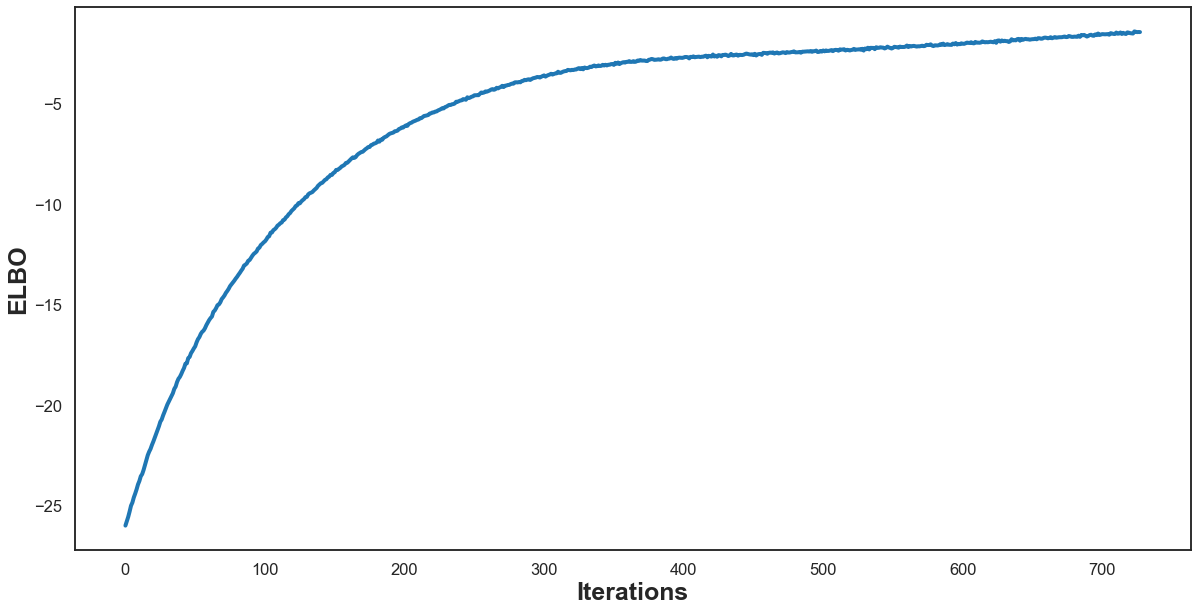

In [115]:
sns.set_context('talk')

elbo = bints.elbo_track
elbo = elbo.detach().numpy()
f,ax=plt.subplots(figsize=(20,10))

ax.set_ylabel('ELBO',fontsize=25,fontweight='bold')

ax.set_xlabel('Iterations',fontsize=25,fontweight='bold')
#ax.set_yscale('log')
ax.plot(elbo[1:],linewidth=4)


### Visualize predicted likelihood

### Visualize error between estimated and true parameters

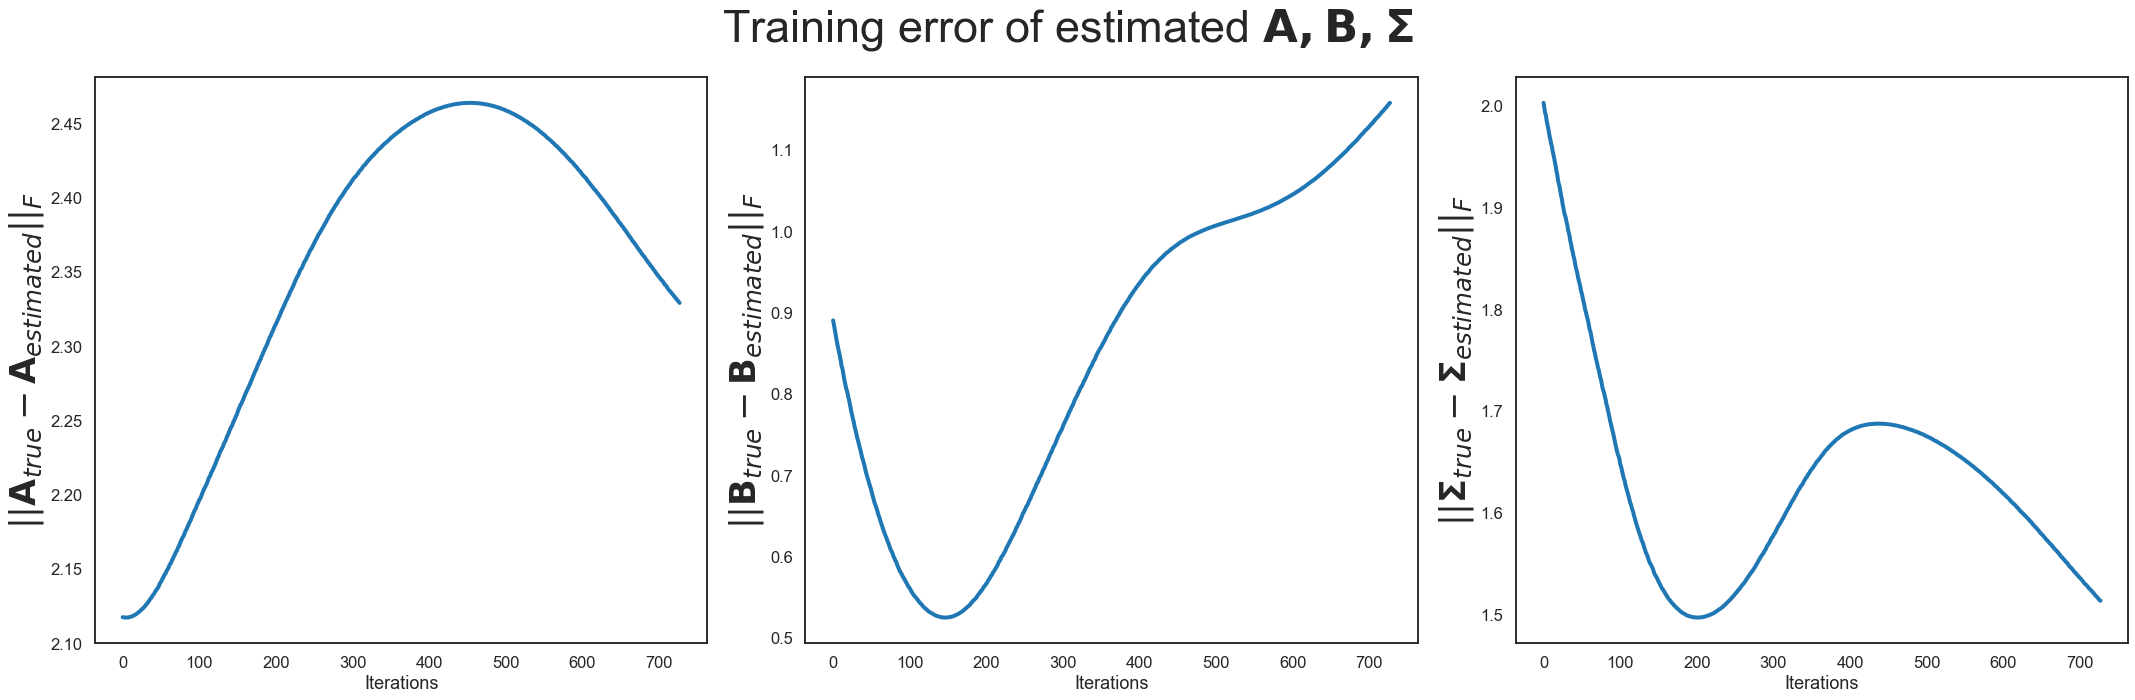

In [116]:
f,ax = plt.subplots(1,3,figsize=(30,10))


f.suptitle('Training error of estimated $\mathbf{A,B,\Sigma}$', fontsize=45)

ax[0].plot(bints.A_error_track[1:],linewidth=4)
ax[0].set_ylabel('$||\mathbf{A}_{true}-\mathbf{A}_{estimated}||_F$',fontsize=35)
ax[1].plot(bints.B_error_track[1:],linewidth=4)
ax[1].set_ylabel('$||\mathbf{B}_{true}-\mathbf{B}_{estimated}||_F$',fontsize=35)
ax[2].plot(bints.sigma_inv_error_track[1:],linewidth=4)
ax[2].set_ylabel('$||\mathbf{\Sigma}_{true}-\mathbf{\Sigma}_{estimated}||_F$',fontsize=35)

for i in [0,1,2]: 
    
    
    ax[i].set_xlabel('Iterations')
plt.tight_layout()

### Vizualise gradients 

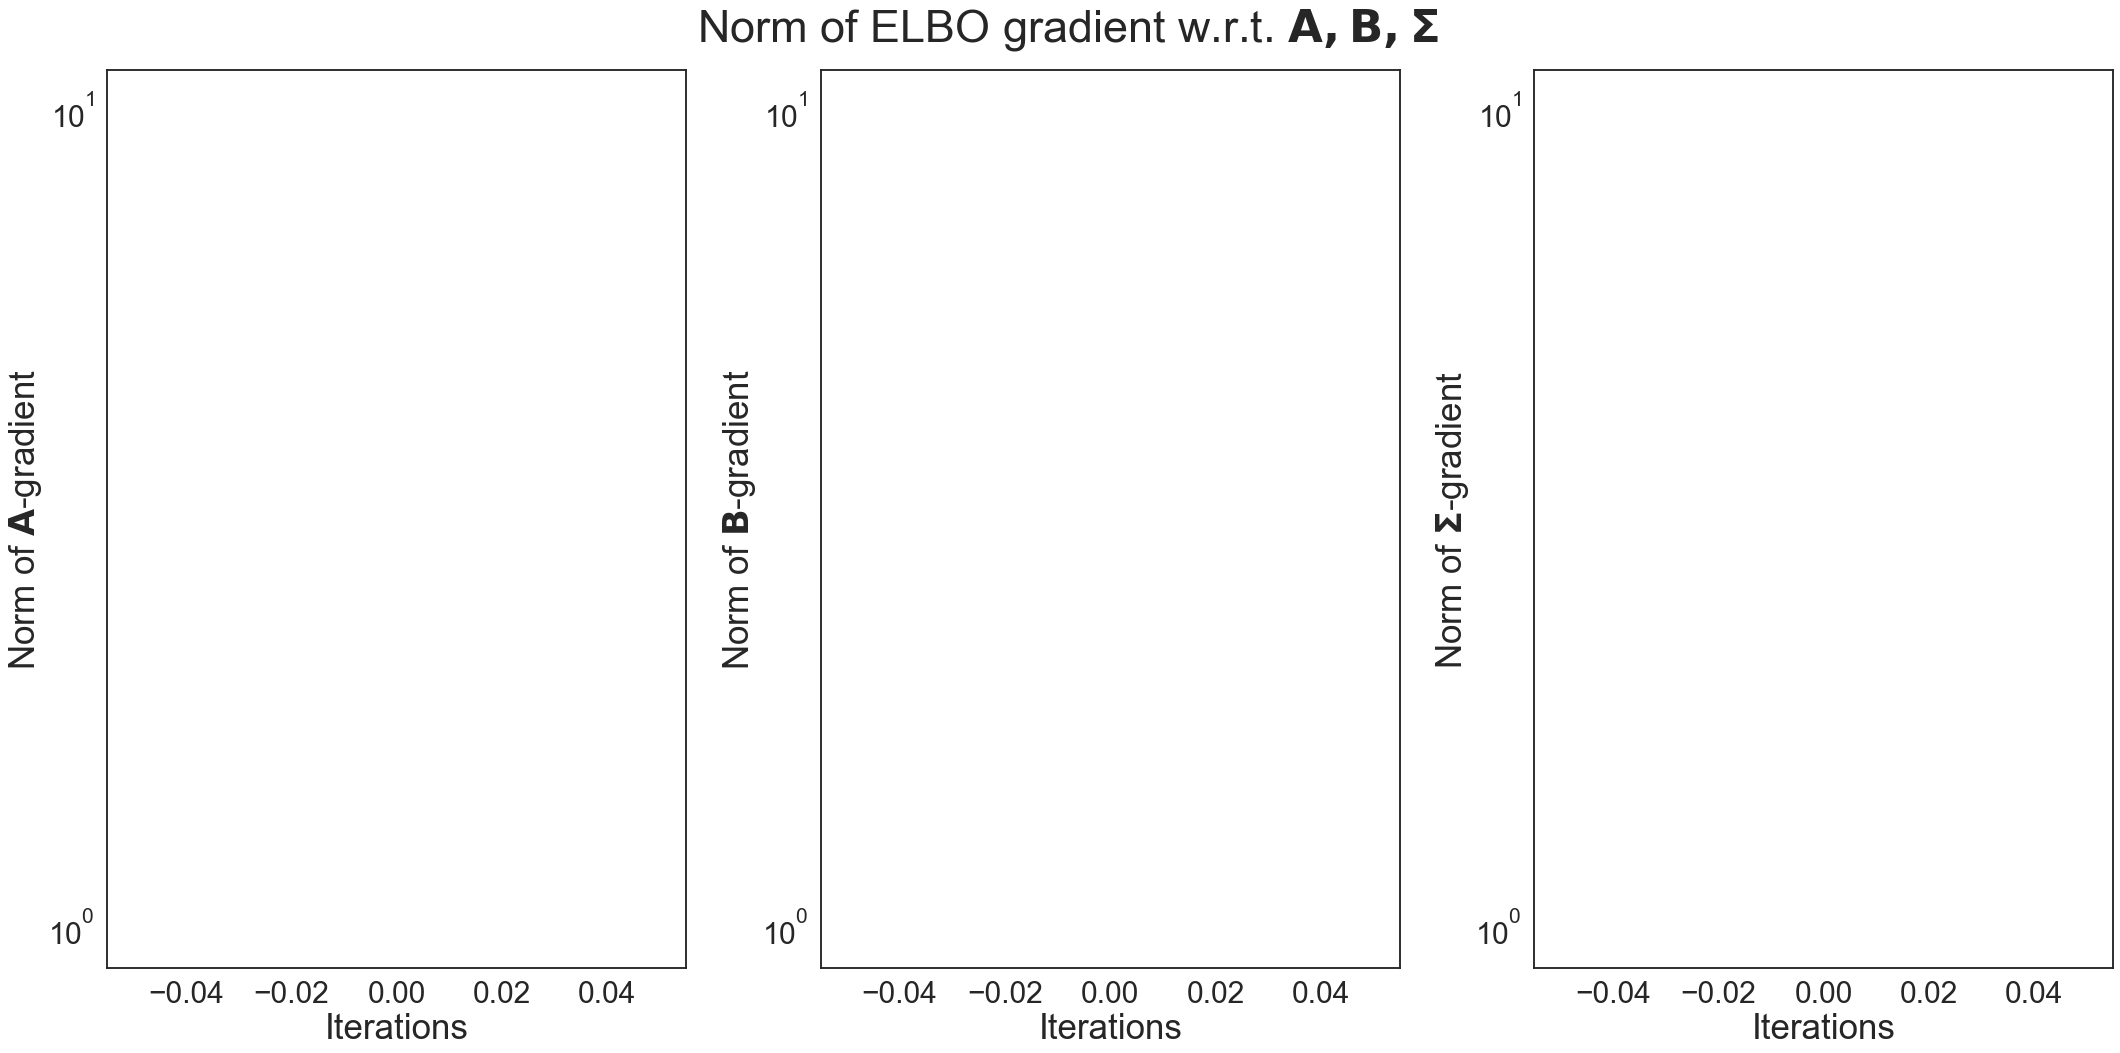

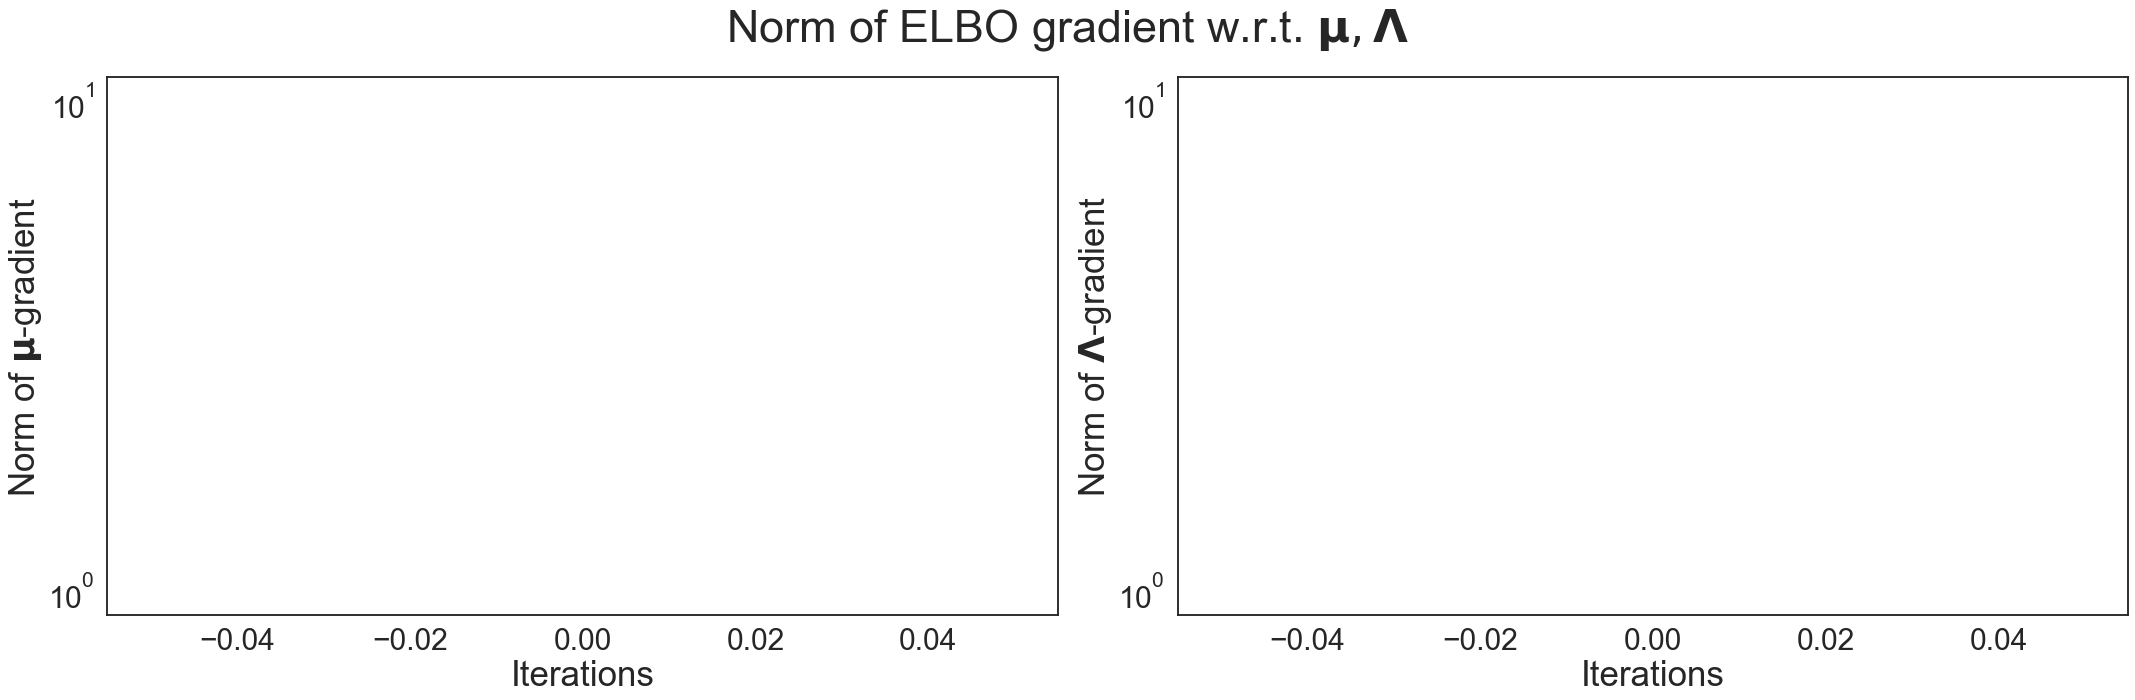

In [105]:
f,ax = plt.subplots(1,3,figsize=(30,15))



f.suptitle('Norm of ELBO gradient w.r.t. $\mathbf{A,B,\Sigma}$', fontsize=45)


ax[0].plot(bints.A_grad_track[1:],c='red',linewidth=4)
ax[0].set_ylabel('Norm of $\mathbf{A}$-gradient',fontsize=35)
ax[0].set_yscale('log')
ax[1].plot(bints.B_grad_track[1:],c='blue',linewidth=4)
ax[1].set_ylabel('Norm of $\mathbf{B}$-gradient',fontsize=35)
ax[1].set_yscale('log')
ax[2].plot(bints.sigma_inv_grad_track[1:], c='purple',linewidth=4)
ax[2].set_ylabel('Norm of $\mathbf{\Sigma}$-gradient',fontsize=35)
ax[2].set_yscale('log')


for i in [0,1,2]: 
    ax[i].set_xlabel('Iterations',fontsize=35)
    ax[i].tick_params(axis='both', which='major', labelsize=30)

    
plt.tight_layout()
plt.show()

f,ax = plt.subplots(1,2,figsize=(30,10))

f.suptitle('Norm of ELBO gradient w.r.t. $\mathbf{\mu}, \mathbf{\Lambda}$', fontsize=45)


ax[0].plot(bints.mu_approx_grad_track[1:],c='red',linewidth=4)
ax[0].set_ylabel('Norm of $\mathbf{\mu}$-gradient',fontsize=35)
ax[0].set_yscale('log')
ax[1].plot(bints.var_approx_grad_track[1:],c='blue',linewidth=4)
ax[1].set_ylabel('Norm of $\mathbf{\Lambda}$-gradient',fontsize=35)
ax[1].set_yscale('log')

for i in [0,1]: 
    
    ax[i].set_xlabel('Iterations',fontsize=35)
    ax[i].tick_params(axis='both', which='major', labelsize=30)

    
plt.tight_layout()
plt.show()

### Vizualise evolution of $\mathbf{A}$

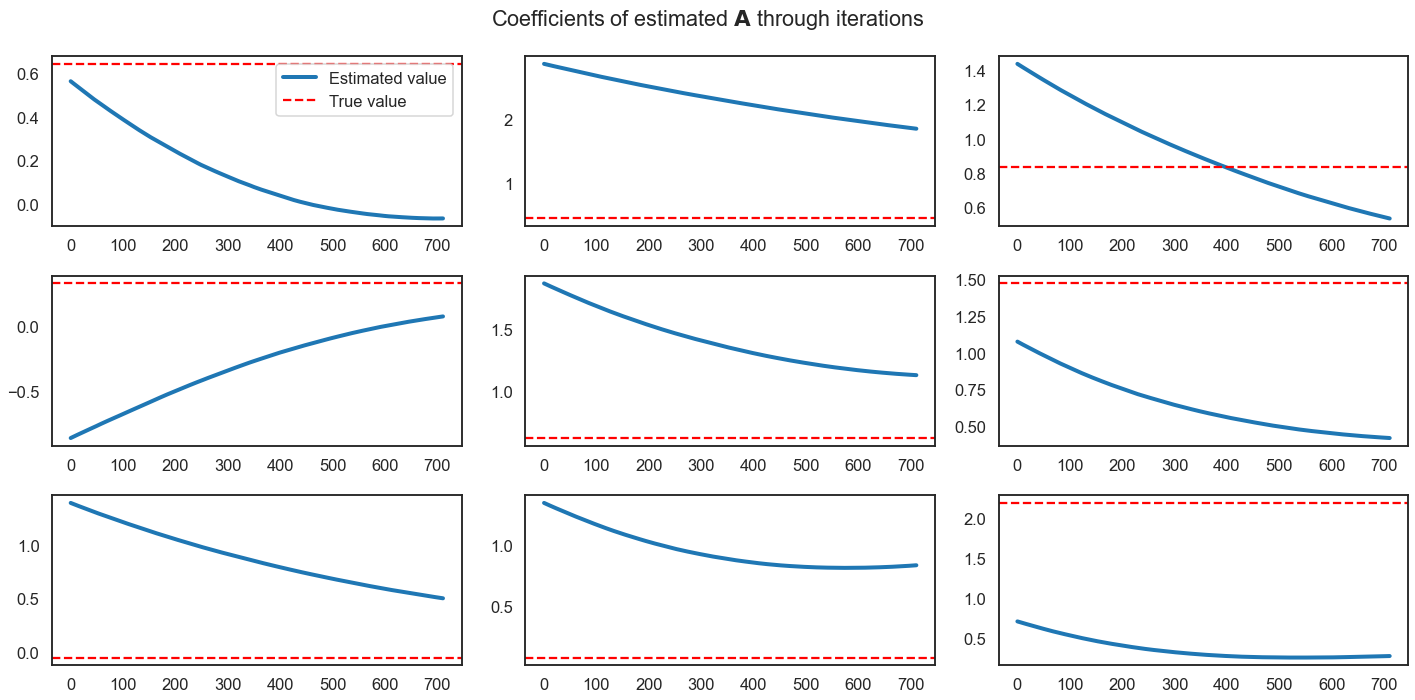

In [228]:
f,ax=plt.subplots(d,d,figsize=(20,10))
reshaped_A_track = bints.A_track.reshape(-1,d,d).detach().numpy()

f.suptitle('Coefficients of estimated $\mathbf{A}$ through iterations')


for i in np.arange(d): 
    for j in np.arange(d):
        ax[i,j].plot(reshaped_A_track[1:,i,j],label='Estimated value',linewidth=4)
        
        ax[i,j].axhline(y = bints.true_A[i,j], color = 'r', linestyle = '--',label='True value')
        
        if i==0 and j==0:
            ax[i,j].legend()
        
        
        
        
plt.tight_layout()

### Visualise evolution of $\mathbf{B}$

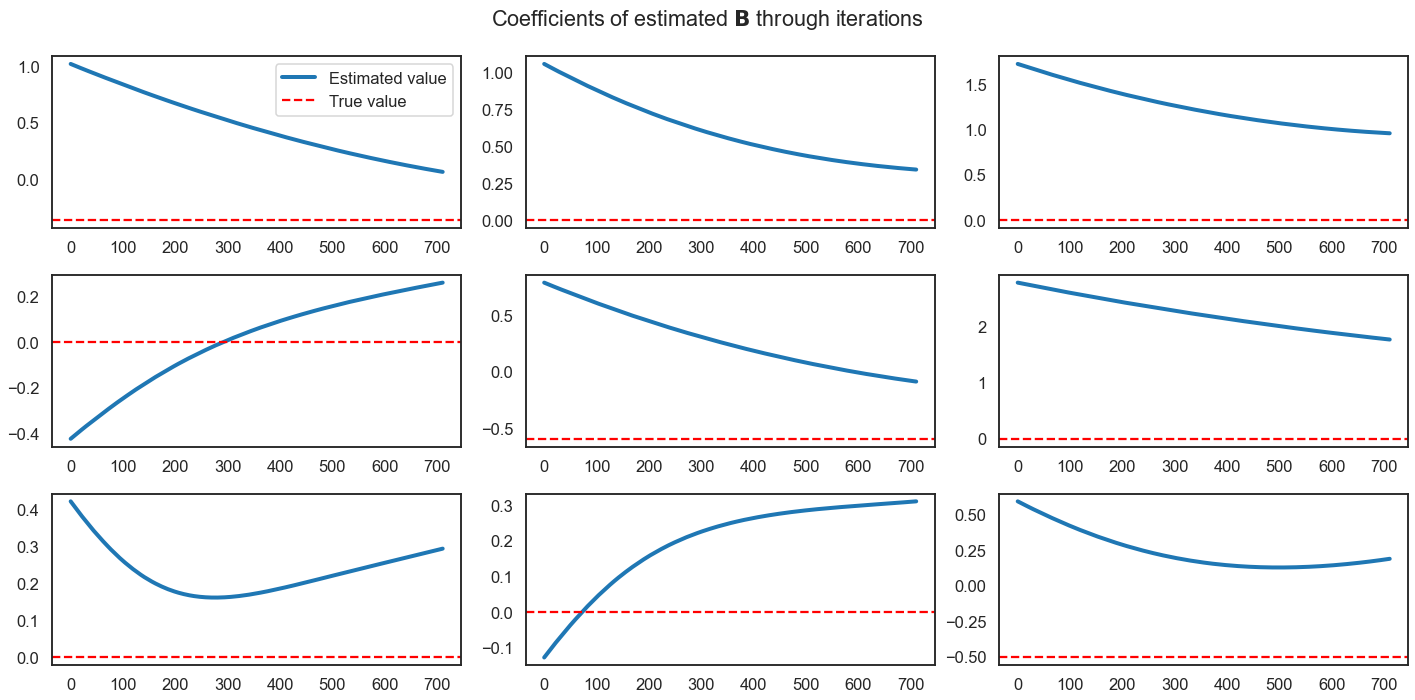

In [229]:
f,ax=plt.subplots(d,d,figsize=(20,10))
reshaped_B_track = bints.B_track.reshape(-1,d,d).detach().numpy()
f.suptitle('Coefficients of estimated $\mathbf{B}$ through iterations')


for i in np.arange(d): 
    for j in np.arange(d):
        
        ax[i,j].plot(reshaped_B_track[1:,i,j],label='Estimated value',linewidth=4)
        ax[i,j].axhline(y = bints.true_B[i,j], color = 'r', linestyle = '--',label='True value')
        
        if i==0 and j==0:
            ax[i,j].legend()
        
plt.tight_layout()


### Visualise evolution of $\mathbf{\Sigma}$

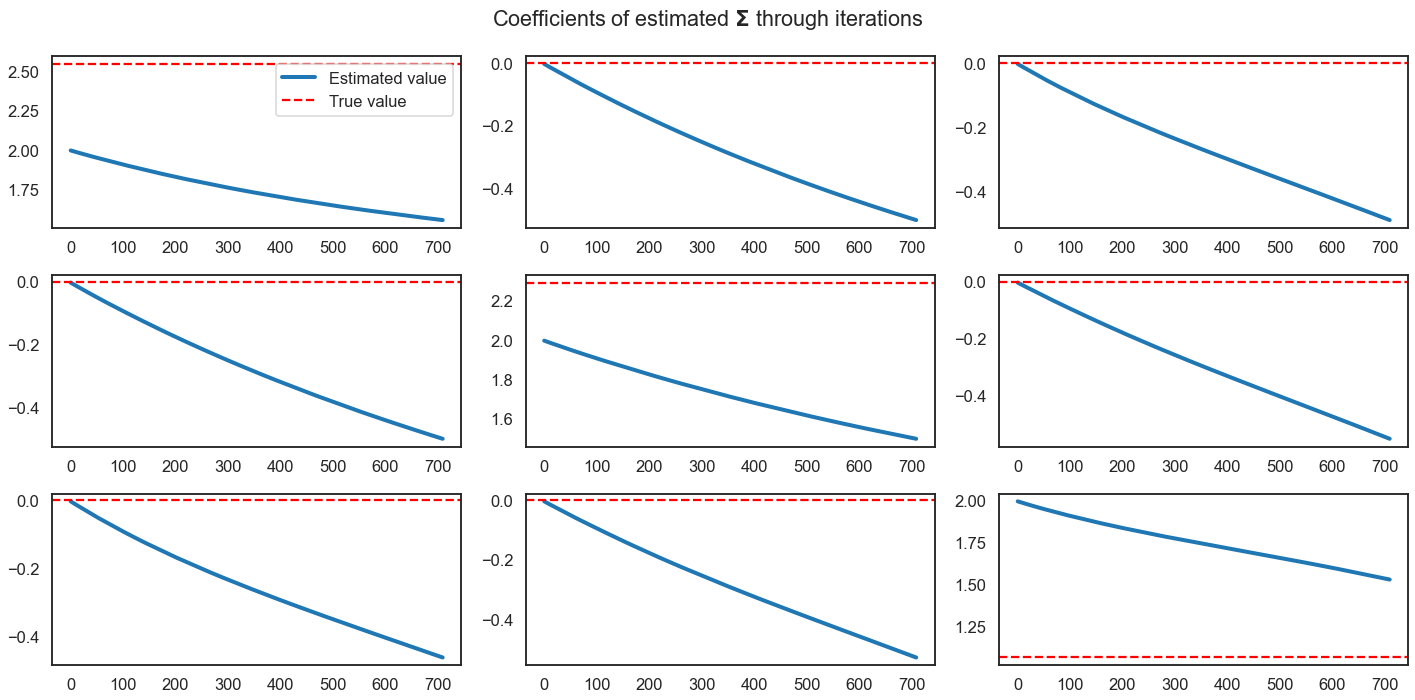

In [231]:
f,ax=plt.subplots(d,d,figsize=(20,10))
reshaped_sigma_inv_track = bints.sigma_inv_track.reshape(-1,d,d).detach().numpy()
f.suptitle('Coefficients of estimated $\mathbf{\Sigma}$ through iterations')

for i in np.arange(d): 
    
    for j in np.arange(d):
        
        ax[i,j].plot(reshaped_sigma_inv_track[3:,i,j], label='Estimated value',linewidth=4)
        
        ax[i,j].axhline(y = bints.true_sigma[i,j], color = 'r', linestyle = '--',label='True value')
        
        if i==0 and j==0:
            ax[i,j].legend()
        
plt.tight_layout()


In [232]:
mu_track = bints.mu_approx_track

In [233]:
mu_track = mu_track.reshape(-1,d,T)

tensor([[0.3200, 0.2940, 0.3760],
        [0.3680, 0.3720, 0.3240],
        [0.3360, 0.3000, 0.3080]])


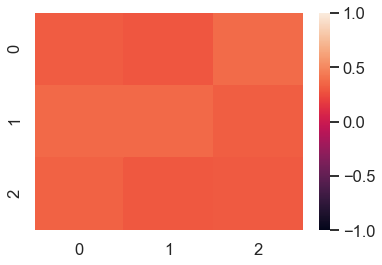

tensor([[0.3200, 0.2940, 0.3760],
        [0.3680, 0.3720, 0.3240],
        [0.3360, 0.3000, 0.3080]])


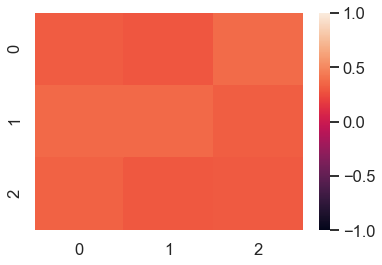

In [234]:
sns.heatmap(mu_track[1,:,:],vmin=-1,vmax=1)
print(mu_track[1,:,:])
plt.show()
sns.heatmap(mu_track[-1,:,:],vmin=-1,vmax=1)
print(mu_track[-1,:,:])

In [237]:
var_track = bints.var_approx_track

In [238]:
var_track = var_track[1:].reshape(-1,d,T,T)

RuntimeError: shape '[-1, 3, 3, 3]' is invalid for input of size 19242

In [239]:
for j in bints.mu_dic.keys():
    print(bints.mu_dic[j]["variable"].grad)

tensor(149.5383)
tensor(-809.2573)
tensor(-842.9151)
tensor(275.4905)
tensor(-273.7760)
tensor(-484.5566)
tensor(1019.5635)
tensor(715.2986)
tensor(-171.2047)


In [240]:
(sum([(bints.mu_dic[key]["variable"].grad)**2 for key in bints.mu_dic.keys()]))**(1/2)

tensor(1831.3605)

In [426]:
(sum([(bints.var_dic[key]["variable"].grad)**2 for key in bints.var_dic.keys()]))**(1/2)

tensor(492.1973)

In [428]:
a = np.arange(10)

In [429]:
a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [431]:
a[:-1]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])